### RNN with my own pre-trained vectors (by CBOW)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from nltk.tokenize import TweetTokenizer

import tensorflow as tf
from tensorflow.contrib.rnn import GRUCell
from tensorflow.python.ops.rnn import dynamic_rnn as rnn
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn

from keras.datasets import imdb
import os
import helpers.preprocessing as prep
import helpers.regprep as regprep
# to perform evaluations (new one - mines)
import helpers.evaluate as ev
evaluator = ev.Evaluate()
import matplotlib.pyplot as plt
%matplotlib inline
import helpers.pickle_helpers as ph
import gensim
from gensim.models import KeyedVectors
import time
import math
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
from sklearn.cross_validation import train_test_split
import re

/home/ellfae/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ellfae/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Parameters

In [3]:
NUM_WORDS = 10000 # max size of vocabulary
EMBEDDING_DIM = 128
HIDDEN_SIZE = 256
ATTENTION_SIZE = 150
KEEP_PROB = 0.8
BATCH_SIZE = 128
NUM_EPOCHS = 50 # Model easily overfits without pre-trained words embeddings, that's why train for a few epochs
DELTA = 0.5
NUM_LAYERS = 3
LEARNING_RATE = 0.0001

### Data Preparation
- Preprocess using Husein helpers

In [4]:
train_data = ph.load_from_pickle(directory="data/husein_emotion/emotion-english/merged_training.pkl")

In [5]:
### TODO: move this preprocessing helper functions
def clearstring(string):
    string = re.sub('[^\'\"A-Za-z0-9 ]+', '', string)
    string = string.split(' ')
    string = filter(None, string)
    string = [y.strip() for y in string]
    string = [y for y in string if len(y) > 3 and y.find('nbsp') < 0]
    return ' '.join(string)

def read_data_with_pandas():
    """ I already converted the data into pandas to we can avoid the function above"""
    vocab = []
    text = train_data.text.values.tolist()
    for t in text:
        strings = clearstring(t)
        vocab+=strings.split()
    return vocab

In [6]:
train_data.text = train_data.text.apply(lambda d: clearstring(d))

In [7]:
### split and sample
train_data, test_data, val_data = prep.split_original(train_data, 20)

In [8]:
### Sampling
#train_data = train_data.sample(n=10000, random_state=10).copy()
#test_data = test_data.sample(n=10000, random_state=10).copy()
#val_data = val_data.sample(n=10000, random_state=10).copy()

### Obtain word embeddings

In [9]:
### load word embeddings and accompanyig vocabulary
wv = ph.load_from_pickle("data/husein_emotion/tf_embeddings/tf_cbow_embeddings.p")
vocab = ph.load_from_pickle("data/husein_emotion/tf_embeddings/tf_cbow_dictionary.p")

In [10]:
### eg. to obtain embedding for token
wv[vocab["feel"]].shape

(128,)

### Tokenization and Label Binarization

In [11]:
def remove_unknown_words(tokens):
    return [t for t in tokens if t in vocab]

def check_size(c, size):
    if len(c) <= size:
        return False
    else:
        return True
    
### tokens and tokensize
train_data["tokens"] = train_data.text.apply(lambda t: remove_unknown_words(t.split()))
train_data["tokensize"] = train_data.tokens.apply(lambda t: len(t))
test_data["tokens"] = test_data.text.apply(lambda t: remove_unknown_words(t.split()))
test_data["tokensize"] = test_data.tokens.apply(lambda t: len(t))
val_data["tokens"] = val_data.text.apply(lambda t: remove_unknown_words(t.split()))
val_data["tokensize"] = val_data.tokens.apply(lambda t: len(t))


### filter by tokensize
train_data = train_data.loc[train_data["tokens"].apply(lambda d: check_size(d, 7)) != False].copy()
test_data = test_data.loc[test_data["tokens"].apply(lambda d: check_size(d, 7)) != False].copy()
val_data = val_data.loc[val_data["tokens"].apply(lambda d: check_size(d, 7)) != False].copy()

### sorting by tokensize
train_data.sort_values(by="tokensize", ascending=True, inplace=True)
test_data.sort_values(by="tokensize", ascending=True, inplace=True)
val_data.sort_values(by="tokensize", ascending=True, inplace=True)

### resetting index
train_data.reset_index(drop=True, inplace=True);
test_data.reset_index(drop=True, inplace=True);
val_data.reset_index(drop=True, inplace=True);

### Binarization
emotions = list(set(train_data.emotions.unique()))
num_emotions = len(emotions)

# binarizer
mlb = preprocessing.MultiLabelBinarizer()

train_data_labels =  [set(emos) & set(emotions) for emos in train_data[['emotions']].values]
test_data_labels =  [set(emos) & set(emotions) for emos in test_data[['emotions']].values]
val_data_labels =  [set(emos) & set(emotions) for emos in val_data[['emotions']].values]

y_bin_emotions = mlb.fit_transform(train_data_labels)
test_y_bin_emotions = mlb.fit_transform(test_data_labels)
val_y_bin_emotions = mlb.fit_transform(val_data_labels)

train_data['bin_emotions'] = y_bin_emotions.tolist()
test_data['bin_emotions'] = test_y_bin_emotions.tolist()
val_data['bin_emotions'] = val_y_bin_emotions.tolist()

### Batching by Bucketing approach

In [12]:
### renders embeddings with paddings; zeros where missing tokens
def generate_embeds_with_pads(tokens, max_size):
   
    padded_embedding = []
    for i in range(max_size):
        if i+1 > len(tokens): # do padding
            padded_embedding.append(list(np.zeros(EMBEDDING_DIM)))
        else: # do embedding for existing tokens
            padded_embedding.append(list(wv[vocab[tokens[i]]]))  
    return padded_embedding

### generate the actual batches
def generate_batches(data, batch_size):
    actual_batches = math.ceil(len(data) / batch_size)
    bins = np.linspace(0, len(data), actual_batches + 1) # this renders actual batches bins of size batch_size
    groups = data.groupby(np.digitize(data.index, bins))
    
    groups_indices = groups.indices
    groups_maxes = groups.max().tokensize
    
    return groups.indices, groups_maxes

### Model

In [13]:
class EmoNet:    
    def __init__(self, num_layers, size_layer, dimension_input, dimension_output, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer)
        ### input
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)])
        self.X = tf.placeholder(tf.float32, [None, None, dimension_input])
        self.Y = tf.placeholder(tf.float32, [None, dimension_output])
        drop = tf.contrib.rnn.DropoutWrapper(self.rnn_cells, output_keep_prob = 0.5)
        
        ### forward
        self.outputs, self.last_state = tf.nn.dynamic_rnn(drop, self.X, dtype = tf.float32)
        self.rnn_W = tf.Variable(tf.random_normal((size_layer, dimension_output)))
        self.rnn_B = tf.Variable(tf.random_normal([dimension_output]))
        
        ### loss, optimization, accuracy
        self.logits = tf.matmul(self.outputs[:, -1], self.rnn_W) + self.rnn_B
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        l2 = sum(0.0005 * tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
        self.cost += l2
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

### Training

In [14]:
### define model
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = EmoNet(NUM_LAYERS, HIDDEN_SIZE, EMBEDDING_DIM, num_emotions, LEARNING_RATE)
sess.run(tf.global_variables_initializer())
dimension = EMBEDDING_DIM
saver = tf.train.Saver(tf.global_variables())
EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 10, 0, 0, 0

### defining batch generation
train_groups_indices, train_groups_maxes = generate_batches(train_data, BATCH_SIZE)
test_groups_indices, test_groups_maxes = generate_batches(test_data, BATCH_SIZE)
val_groups_indices, val_groups_maxes = generate_batches(val_data, BATCH_SIZE)

n_train = len(train_data) // BATCH_SIZE
n_test = len(test_data) // BATCH_SIZE
n_val = len(val_data) // BATCH_SIZE

In [15]:
### training
while True:
    lasttime = time.time()
    ### early stoping to avoid overfitting
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:', EPOCH)
        break
    train_acc, train_loss, val_acc , val_loss = 0, 0, 0, 0
    
    for b in range(n_train):
        batch_x = train_data.iloc[train_groups_indices[b+1]].tokens.apply(lambda d: 
                                                                          generate_embeds_with_pads(d, train_groups_maxes[b+1]) ).values.tolist()
        batch_y = train_data.loc[train_groups_indices[b+1]].bin_emotions.values.tolist()
        #print(batch_x)
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X : batch_x, model.Y : batch_y})
        train_loss += loss
        train_acc += sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y})
    
    for b in range(n_val):
        batch_x = val_data.iloc[val_groups_indices[b+1]].tokens.apply(lambda d: 
                                                                          generate_embeds_with_pads(d, val_groups_maxes[b+1]) ).values.tolist()
        batch_y = val_data.loc[val_groups_indices[b+1]].bin_emotions.values.tolist()
        loss, acc = sess.run([model.cost, model.accuracy], feed_dict = {model.X : batch_x, model.Y : batch_y})
        val_loss += loss
        val_acc += acc
    
    train_loss /= n_train
    train_acc /= n_train
    val_loss /= n_val
    val_acc /= n_val
    
    if val_acc > CURRENT_ACC:
        print('epoch:', EPOCH, ', pass acc:', CURRENT_ACC, ', current acc:', val_acc)
        CURRENT_ACC = val_acc
        CURRENT_CHECKPOINT = 0
        saver.save(sess, os.getcwd() + "/model/acl/model-rnn-vector.ckpt")
    else:
        CURRENT_CHECKPOINT += 1
    EPOCH += 1
    print('time taken:', time.time()-lasttime)
    print('epoch:', EPOCH, ', training loss:', train_loss, ', training acc:', train_acc, ', valid loss:', val_loss, ', valid acc:', val_acc)

epoch: 0 , pass acc: 0 , current acc: 0.44793318906455365
time taken: 120.65529823303223
epoch: 1 , training loss: 1.8497494605181795 , training acc: 0.48508491165136264 , valid loss: 1.8182489947207923 , valid acc: 0.44793318906455365
epoch: 1 , pass acc: 0.44793318906455365 , current acc: 0.4703425406252296
time taken: 121.70198845863342
epoch: 2 , training loss: 1.660787812719351 , training acc: 0.5180269489691719 , valid loss: 1.7152376516351422 , valid acc: 0.4703425406252296
epoch: 2 , pass acc: 0.4703425406252296 , current acc: 0.5126047536586095
time taken: 121.93270444869995
epoch: 3 , training loss: 1.5584344023860102 , training acc: 0.546390782058998 , valid loss: 1.5831360064663933 , valid acc: 0.5126047536586095
epoch: 3 , pass acc: 0.5126047536586095 , current acc: 0.5833902684519592
time taken: 121.7117645740509
epoch: 4 , training loss: 1.4278881854906886 , training acc: 0.5927821245245531 , valid loss: 1.4361504096429325 , valid acc: 0.5833902684519592
epoch: 4 , pass 

KeyboardInterrupt: 

### Evaluation on Testing dataset

In [16]:
saver = tf.train.import_meta_graph("model/acl/model-rnn-vector.ckpt.meta")

In [22]:
test_acc = 0
all_predictions = []
x_raw = []
y_raw = []
with tf.Session() as sess:
    saver.restore(sess, "model/acl/model-rnn-vector.ckpt")
    for b in range(n_test):
        batch_x = test_data.iloc[test_groups_indices[b+1]].tokens.apply(lambda d: 
                                                                          generate_embeds_with_pads(d, test_groups_maxes[b+1]) ).values.tolist()
        batch_y = test_data.loc[test_groups_indices[b+1]].bin_emotions.values.tolist()
        
        ### store these batches
        x_raw = x_raw +[x for x in batch_x]
        y_raw = y_raw + [y for y in batch_y]
        
        predictions, acc = sess.run([model.logits, model.accuracy], feed_dict = {model.X : batch_x, model.Y : batch_y})
        
        all_predictions.append(predictions)
        test_acc += acc
    
    test_acc /= n_test
    print('Test: %.4f' % (test_acc))    

INFO:tensorflow:Restoring parameters from model/acl/model-rnn-vector.ckpt
Test: 0.8994


In [24]:
final_predictions = []

for p in all_predictions:
    for sub_p in p:
        #print(sub_p)
        final_predictions.append(sub_p)
        
all_predictions = [np.argmax(p) for p in final_predictions]
        
correct_predictions = float(sum(all_predictions == np.argmax(y_raw, axis=1)))

In [25]:
correct_predictions

23625.0

Default Classification report
             precision    recall  f1-score   support

      anger       0.91      0.87      0.89      3504
       fear       0.90      0.84      0.87      2960
        joy       0.91      0.93      0.92      9227
       love       0.82      0.75      0.78      2366
    sadness       0.92      0.95      0.93      7203
   surprise       0.78      0.86      0.82      1008

avg / total       0.90      0.90      0.90     26268


Accuracy:
0.8993832800365463
Correct Predictions:  23625
precision: 0.87
recall: 0.87
f1: 0.87

confusion matrix
 [[3064  100   72    9  258    1]
 [ 104 2490   57    2  135  172]
 [  36   15 8619  365  131   61]
 [  29   10  503 1769   52    3]
 [ 152   83  123   18 6817   10]
 [   0   80   46    1   15  866]]
(row=expected, col=predicted)


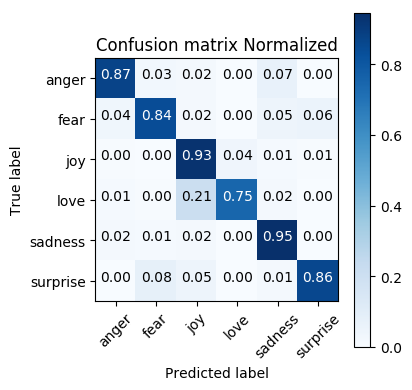

In [32]:
# predictions
predictions_human_readable = ((x_raw, all_predictions))
# actual targets
target_human_readable = ((x_raw,  np.argmax(y_raw, axis=1)))

### {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}
num_emotion_dict = {i:c for i,c in enumerate(mlb.classes_)}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: num_emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: num_emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );